### 環境構築
環境構築ソフト[pixi](https://pixi.sh/ "pixi公式")を使用して環境構築を行う。
1. 「ファイル」，「フォルダを開く」からこのノートブックファイルが直下に入っているフォルダを開く。zipファイルは同名フォルダが2重になっているので注意
1. 画面下部にカーソルを持っていき，アイコンが変わったらクリックしたまま上にドラッグするとターミナルが開く（またはCtrlと`の同時押し）
1. 開いたターミナルに，「pixi shell」と打ち込むと環境が構築できる。

## インポート
[AI開発用ライブラリpytorch](https://pytorch.org/ "pytorch公式")を主として，必要なライブラリをインポートする。

In [1]:
import tqdm
import pandas as pd
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


条件記録変数の初期化

In [2]:
parameters = {}

### データの読み込み
表形式のデータを扱うのに長けた，[pandas](https://pandas.pydata.org/ "pandas公式")でデータを読み込む。
pandasにはread_csv()やread_excel()関数があり，一般的な表形式データをそのまま読み込むことができる。

In [3]:
df = pd.read_csv("./data/02D_regression_WindAndSolarPowerPrediction.csv")

Jupyter Notebook形式でスクリプトを書いている場合，セルの最終行に変数名だけを記載した場合，その内容が表示される。
その他の場所で表示がしたい場合はprint()関数の使用が必要

In [4]:
df

Date and Hour       Date  StartHour  EndHour  \
0      2020-01-01 00:00:00+01:00   2020/1/1          0        1   
1      2020-01-01 00:00:00+01:00   2020/1/1          0        1   
2      2020-01-01 01:00:00+01:00   2020/1/1          1        2   
3      2020-01-01 01:00:00+01:00   2020/1/1          1        2   
4      2020-01-01 02:00:00+01:00   2020/1/1          2        3   
...                          ...        ...        ...      ...   
59801  2023-06-30 21:00:00+02:00  2023/6/30         21       22   
59802  2023-06-30 22:00:00+02:00  2023/6/30         22       23   
59803  2023-06-30 22:00:00+02:00  2023/6/30         22       23   
59804  2023-06-30 23:00:00+02:00  2023/6/30         23       24   
59805  2023-06-30 23:00:00+02:00  2023/6/30         23       24   

       Source(0: Wind, 1: Solar)  Production  dayOfYear    dayName monthName  
0                              0      3549.0          1  Wednesday   January  
1                              1         0.0          1  Wednesday   January  
2                              1         0.0          1  Wednesday   January  
3                              0      2952.0          1  Wednesday   January  
4                              1         0.0          1  Wednesday   January  
...                          ...         ...        ...        ...       ...  
59801                          1        50.0        181     Friday      June  
59802                          0      5140.0        181     Friday      June  
59803                          1         1.0        181     Friday      June  
59804                          0      6135.0        181     Friday      June  
59805                          1         1.0        181     Friday      June  

[59806 rows x 9 columns]

# データの可視化
import seaborn as sns
でインポートしたseabornモジュールを使用して，各数値間の関係を可視化する。

In [5]:
# データの可視化
#sns.pairplot(df)#, hue="age")
#plt.show()

データの加工

In [6]:
# 文字データは数値として入力できないので，該当列名を指定して削除

df = df.drop(columns=[
    "Date and Hour",
    "Date",
    "dayName",
    "monthName"
    ])
#削除できたか確認
df

StartHour  EndHour  Source(0: Wind, 1: Solar)  Production  dayOfYear
0              0        1                          0      3549.0          1
1              0        1                          1         0.0          1
2              1        2                          1         0.0          1
3              1        2                          0      2952.0          1
4              2        3                          1         0.0          1
...          ...      ...                        ...         ...        ...
59801         21       22                          1        50.0        181
59802         22       23                          0      5140.0        181
59803         22       23                          1         1.0        181
59804         23       24                          0      6135.0        181
59805         23       24                          1         1.0        181

[59806 rows x 5 columns]

In [7]:
# 欠損値(nan)の確認
df.isnull().sum()

StartHour                    0
EndHour                      0
Source(0: Wind, 1: Solar)    0
Production                   2
dayOfYear                    0
dtype: int64

In [8]:
# 欠損値行を削除
df.dropna(inplace=True)
df

StartHour  EndHour  Source(0: Wind, 1: Solar)  Production  dayOfYear
0              0        1                          0      3549.0          1
1              0        1                          1         0.0          1
2              1        2                          1         0.0          1
3              1        2                          0      2952.0          1
4              2        3                          1         0.0          1
...          ...      ...                        ...         ...        ...
59801         21       22                          1        50.0        181
59802         22       23                          0      5140.0        181
59803         22       23                          1         1.0        181
59804         23       24                          0      6135.0        181
59805         23       24                          1         1.0        181

[59804 rows x 5 columns]

In [9]:
# 文字列データを数値に変換
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('float')

## データを訓練・テストに分割
データ全てを使って訓練すると，過学習（問題集の丸暗記に近い状態）となり，初めて見るデータに対する推測性能を知ることができない。
整形したデータの２割を，テストデータ，８割を訓練データとして分割する。

In [10]:
# 回帰（推定）対象を除いたデータをX，回帰対象をyとして分ける
parameters["regression_terget"] = "Production"
X = df.drop(parameters.get("regression_terget"), axis=1)
y = df[parameters.get("regression_terget")]

# 分割の再現性を確保するため，シード値を指定したうえで訓練データ・テストデータに分割（ここは変えない）
parameters["test_size"] = 0.2
parameters["random_seed"] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=parameters.get("test_size"),
                                                    random_state=parameters.get("random_seed"))


分割結果の確認

In [11]:
X_train

StartHour  EndHour  Source(0: Wind, 1: Solar)  dayOfYear
8637          22       23                          1        211
37371         13       14                          1         79
34042          5        6                          0         10
44892          6        7                          0        236
48819          1        2                          1        318
...          ...      ...                        ...        ...
45893          2        3                          0        257
52418          1        2                          0         28
42615         19       20                          0        188
43569         16       17                          1        208
2732          22       23                          0         57

[47843 rows x 4 columns]

In [12]:
X_test.shape

(11961, 4)

In [13]:
y_train.shape

(47843,)

In [14]:
y_test.shape

(11961,)

## データをpytorch用に変換
データを変換し，モデルが読み込めるようにデータローダーを定義する。

In [15]:
# torchテンソルに変換
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

# データローダー定義用に変換
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# データローダー定義
parameters["batch_size"] = 128
train_loader = DataLoader(train_dataset, batch_size=parameters.get('batch_size'), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [16]:
# テンソル形状の確認
for batch, (X, y) in enumerate(train_loader):
    pass
print(f"batch: {batch}, X: {X.shape}, y: {y.shape}")

batch: 373, X: torch.Size([99, 4]), y: torch.Size([99, 1])


## モデルの定義
モデルの定義自体は基本的に前回の分類問題と同様。
変更するのは，入出力データのサイズ。

### 前回の入出力サイズ
入力：縦横28ピクセルのモノクロ画像データのため，１ピクセル毎の輝度データが入力，つまり28×28=784個の数値を入力とした。

出力：10種類の衣類の種類それぞれの確率を数字としたため，10個の数字が出力

### 今回の入出力サイズ
入力：各列のパラメータが対応するため，数値8個を入力する。X.shape[1]は行列の幅を返す。

出力：回帰対象，つまり単一の数値が出力


In [17]:
input_size = X.shape[1]
output_size = 1

In [18]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# モデルのインスタンスを作成
train_error = []; test_error = []; total_epochs = 0
parameters['model'] = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
model = parameters.get('model')
print(parameters['model'])

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): ReLU()
  )
)


## 訓練条件の指定
損失関数，最適化アルゴリズムを指定する。
前回と違うのは，損失関数が単純に数値の誤差のため，MSELoss()を使用する点


In [19]:
parameters['loss_fn'] = nn.MSELoss()
parameters['learning_rate'] = 1e-2
parameters['optimizer'] = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'])

loss_fn = parameters.get('loss_fn')
optimizer = parameters['optimizer']

#学習スケジューラーを入れる場合はここに記述
parameters['scheduler'] = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
#scheduler = parameters['scheduler']

In [20]:
def train(dataloader, model, loss_fn, optimizer, scheduler = None):

    model.train()
    RMSE = 0; size = 0

    for batch, (X, y) in enumerate(dataloader):
        size += 1
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        buf_fn = nn.MSELoss(); RMSE += buf_fn(pred, y).item()        
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    RMSE /= size
    RMSE = RMSE**0.5

    if scheduler is not None:
        try:
            scheduler.step(loss)
        except:
            scheduler.step

    return RMSE


In [21]:
def test(dataloader, model, monitor = False, range = (0,1)):
    size = 0; RMSE = 0
    model.eval()

    if monitor:
        predictions = []
        truths = []

    with torch.no_grad():
        for X, y in dataloader:
            size += 1
            X, y = X.to(device), y.to(device)
            pred = model(X)

            if monitor:
                predictions.append(pred)
                truths.append(y)

            buf_fn = nn.MSELoss(); RMSE += buf_fn(pred, y).item()        
            
    RMSE /= size
    RMSE = RMSE**0.5

    if monitor:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        predictions = torch.cat(predictions).cpu().numpy()
        truths = torch.cat(truths).cpu().numpy()
        print(range)
        plt.plot([range[0],range[1]], [range[0],range[1]], color = "black")
        plt.plot(truths, predictions, "o", color = "black", alpha = 0.5)
        plt.xlabel(f"True")
        plt.ylabel(f"Predicted")
        #rmseをテキストとして枠内に表示
        plt.text(0.05, 0.95, f"RMSE: {RMSE:.2f}", transform=plt.gca().transAxes)
        plt.subplot(1, 2, 2)
        ax2 = plt.gca()
        
        # 表示するテキストを作成
        text = ""
        for key, value in parameters.items():
            if key == 'optimizer':
                value =  str(value)[:5]
            text += f"{key}: {value}\n"

        # Subplot内にテキストを追加
        plt.text(0, 1, text, transform=ax2.transAxes, fontsize=10, verticalalignment='top')

        # グラフのタイトルなどを必要に応じて設定
        plt.title("Parameters")
        plt.axis('off') # 軸を非表示にする

        plt.show()
        
    return RMSE

In [22]:
parameters['epochs'] = 100
total_epochs += parameters['epochs']

for t in tqdm.tqdm(range(parameters['epochs'])):
    train_error.append(train(train_loader, model, loss_fn, optimizer))
    test_error.append(test(test_loader, model, False))
    
print("完了")
print(train_error)

100%|██████████| 100/100 [04:36<00:00,  2.76s/it]

完了
[3320.2629605206494, 2720.5100066943446, 2611.912397137556, 2594.2061601970413, 2580.2329891067716, 2574.9976303140543, 2566.4864484036484, 2561.7311054606203, 2560.4635363000048, 2545.154078523039, 2537.668938555861, 2532.111430431725, 2525.545752822334, 2524.9937070393335, 2517.035714506571, 2512.287940607936, 2507.1959914025097, 2487.457916635392, 2465.5036787045933, 2448.698304616574, 2432.3369392340705, 2406.7540695030557, 2390.7452624149146, 2366.7580364163077, 2348.679042494399, 2338.299604579234, 2331.1508054049414, 2321.607521659436, 2322.57827688815, 2318.0795419270094, 2315.2196805309095, 2308.7699058029098, 2313.2426378002156, 2308.8090534561006, 2313.8775678639895, 2305.8457222139573, 2311.641363934844, 2305.751497650411, 2304.3061507165116, 2305.8882788806454, 2301.581055480455, 2301.402012671945, 2305.9116630074063, 2302.2960039286613, 2304.6006873661554, 2303.734519709132, 2301.1493614474134, 2300.5078622915507, 2296.72809066722, 2294.905437538983, 2298.033944198788,

## 学習曲線の可視化

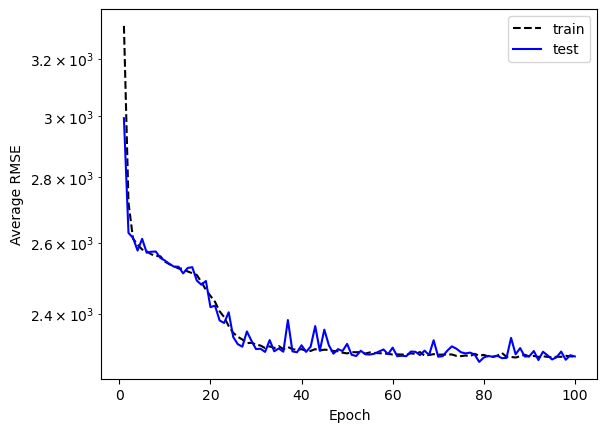

In [23]:

plt.plot(range(1,total_epochs+1), train_error, label="train", color="black", linestyle="dashed")
plt.plot(range(1,total_epochs+1), test_error, label="test", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Average RMSE")
plt.yscale('log')
plt.legend()
plt.show()


train data prediction
(np.float64(0.0), np.float64(17220.0))


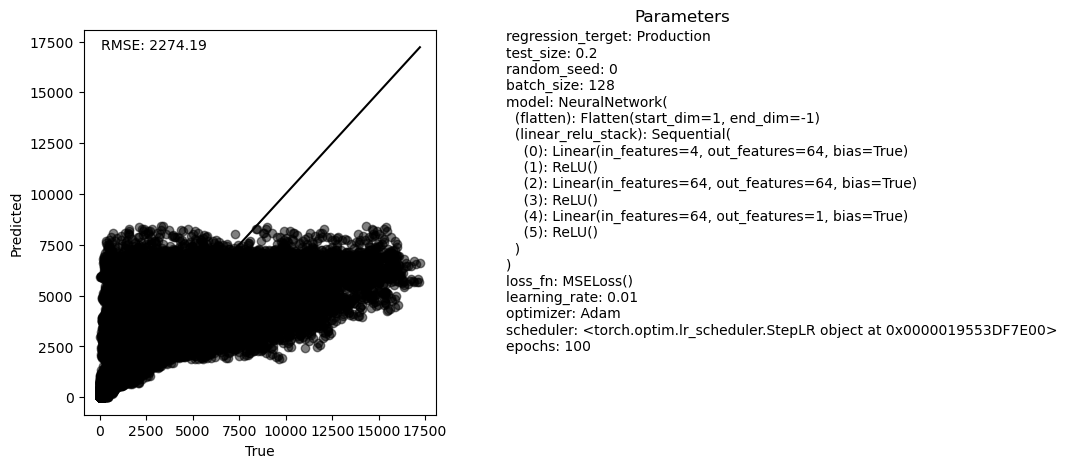

test data prediction
(np.float64(0.0), np.float64(17220.0))


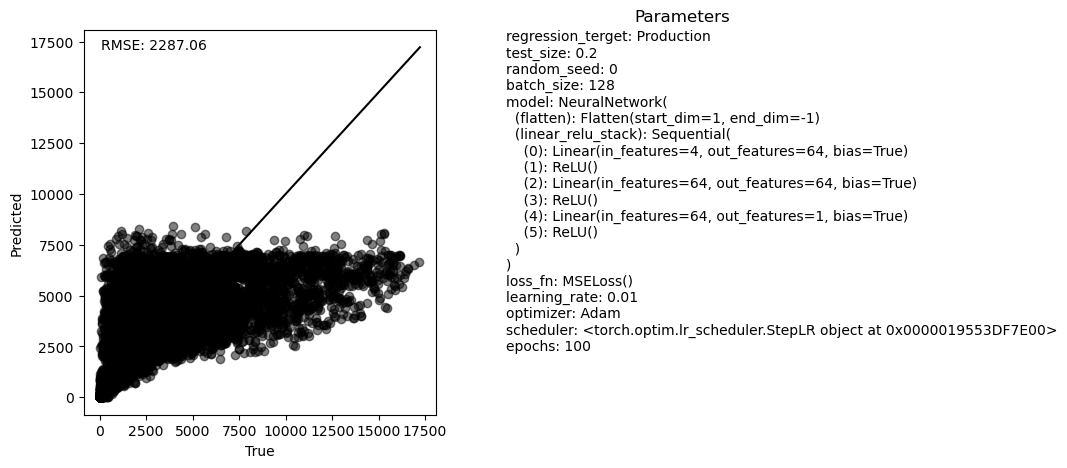

2287.0627997499323

In [24]:
# 訓練データに対する予測結果を表示
print("train data prediction")
test(train_loader, model, monitor=True, range = (df[parameters['regression_terget']].min(), df[parameters['regression_terget']].max()))
# テストデータに対する予測結果を表示
print("test data prediction")
test(test_loader, model, monitor=True, range = (df[parameters['regression_terget']].min(), df[parameters['regression_terget']].max()))

## 精度向上へのヒント
1. データの前処理は正しかったか？
    1. 列によって値のレンジが異なるが，これを同じように入力しても大丈夫？
    1. 合金の名前など，文字で記載された列を削除したが，文字列のデータ（カテゴリデータ）を数値に変換（リンゴ=0,バナナ=2のように置き換え）してヒントとして使えないか
    1. 欠損データを削除したが，その他の列の数値を活用できるようにできないか（平均値で埋めてみる，0で埋めてみる。等）
    1. そもそも，対称を予測するに適切にデータを含んでいたか？追加はできないか？[天気などは指定期間，場所でダウンロードできる](https://open-meteo.com/en/docs)
    
1. 学習量（epoch数）は充分か？
    1. 学習曲線におけるテストデータの誤差が減少傾向であれば，学習不足。
    1. テストデータよりも訓練データに対する誤差が大きい場合も，学習不足の可能性が高い。

1. 学習速度係数(lr)は適切か？
    1. 大きいと収束は早いが安定しにくい。
    1. 小さいと収束結果はいいが学習が遅い。
    1. 学習の途中で学習係数を調整するスケジューラーも存在する（from torch.optim import lr_scheduler）
    
1. batch_sizeは？
    1. 一度に見せるデータの量，基本的には小さい方が高精度とされる
    1. が，小さいと訓練回数が増えるので，学習に時間がかかる。
    1. 一般論では，データサイズの1/100程度がバランスが取れているとされる。

1. モデルの表現力（層の数やニューロンの数）は適切だったか？
    1. 表現力が不足していると，データ全てを包括した特徴を充分に抽出できない。この場合，学習曲線で訓練データの誤差が一定値以上減らなくなる。
    1. 表現力が過剰な場合，過学習（訓練データを丸暗記し，テスト結果が悪くなる）に陥りやすい。この場合，学習曲線において訓練データに対する誤差が減っているにも関わらず，テストデータに対する誤差が増えていく。

1. 活性層は？
    1. Reluは負の値に対して，傾きを持たない。パラメータを変更しても損失が変わらない状況にスタックした場合，学習が進まない。
    1. LeakyReluは負の値にも傾きがある。

1. 損失関数は適切だったか？回帰における誤差評価関数には例えば以下のような種類がある。（今回はRMSEで競うのであまり変更の意味はない）
    1. MSE（Mean Squared Error/2乗平均誤差）：正規分布の分散に相当する。2乗を取ることで本来の値から離れるほど非線形にペナルティが大きくなる
    1. RMSE（Root Mean Squared Error/2乗平均平方根誤差）：正規分布の標準偏差に相当する。本来の値からの距離に対して線形にペナルティを与える。
    1. MAE（Mean Absolute Error/平均絶対値誤差）：誤差自体の平均値
    1. LMSE(Least Mean Square Error/最小2乗平均誤差)：MSEの対数をとった関数。誤差を対数軸（比率）で評価可能になるので，何桁にも渡って分布する（対数軸で評価する）回帰対象に対して適用しやすい。
    

## 同条件でのスコア統計取得
モデルの初期パラメータは，乱数で決定される。ので，同じ方法での訓練でも結果はばらつく。複数回の評価で，本質的に優れた方法かが評価できる。

(np.float64(0.0), np.float64(17220.0))


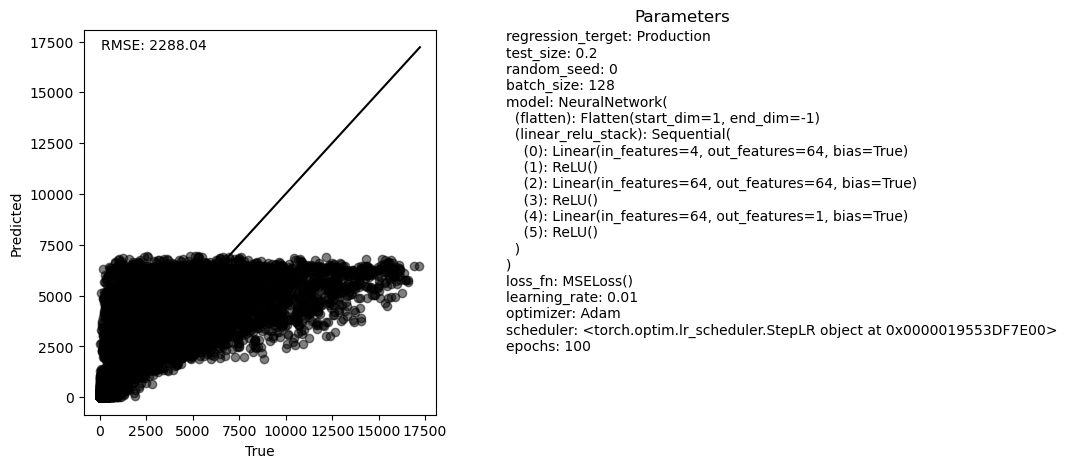

1/30: train_RMSE: 2293.12, test_RMSE: 2288.04(np.float64(0.0), np.float64(17220.0))


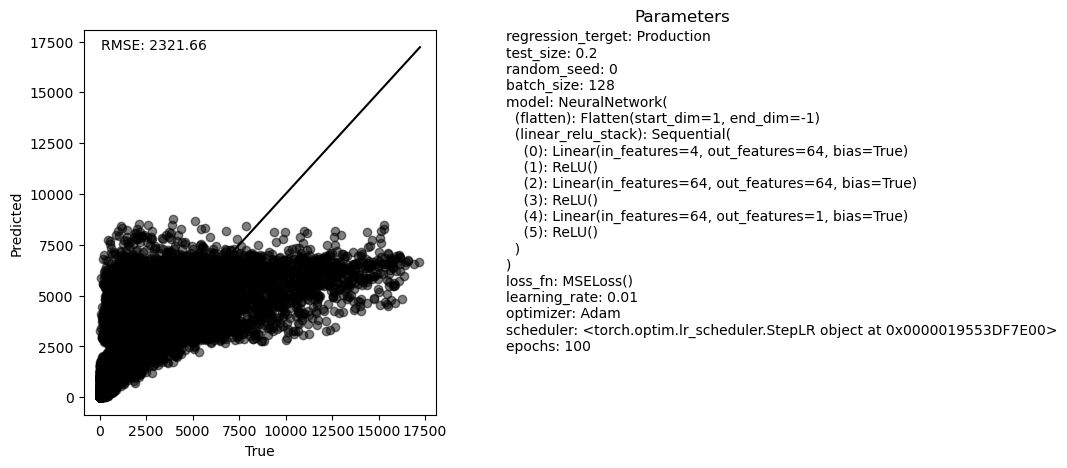

2/30: train_RMSE: 2292.07, test_RMSE: 2321.66(np.float64(0.0), np.float64(17220.0))


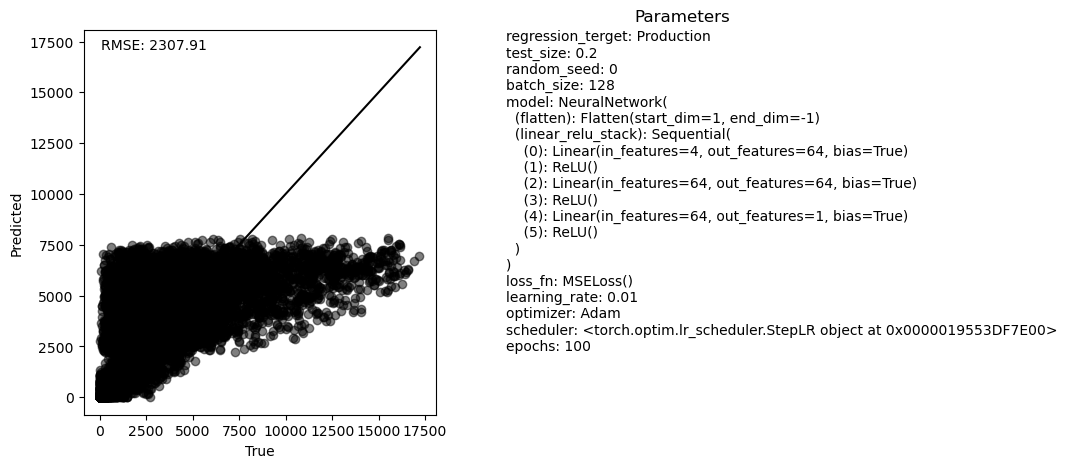

3/30: train_RMSE: 2288.83, test_RMSE: 2307.91(np.float64(0.0), np.float64(17220.0))


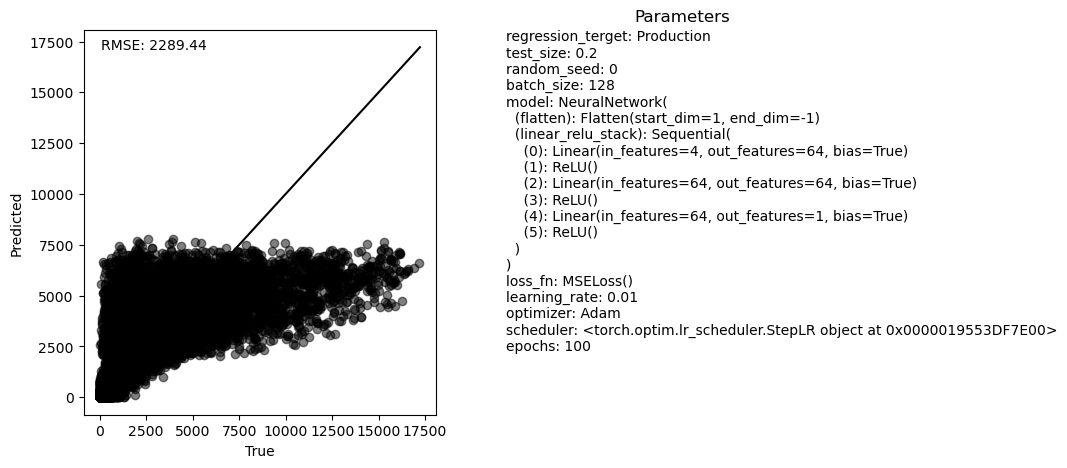

4/30: train_RMSE: 2289.69, test_RMSE: 2289.44(np.float64(0.0), np.float64(17220.0))


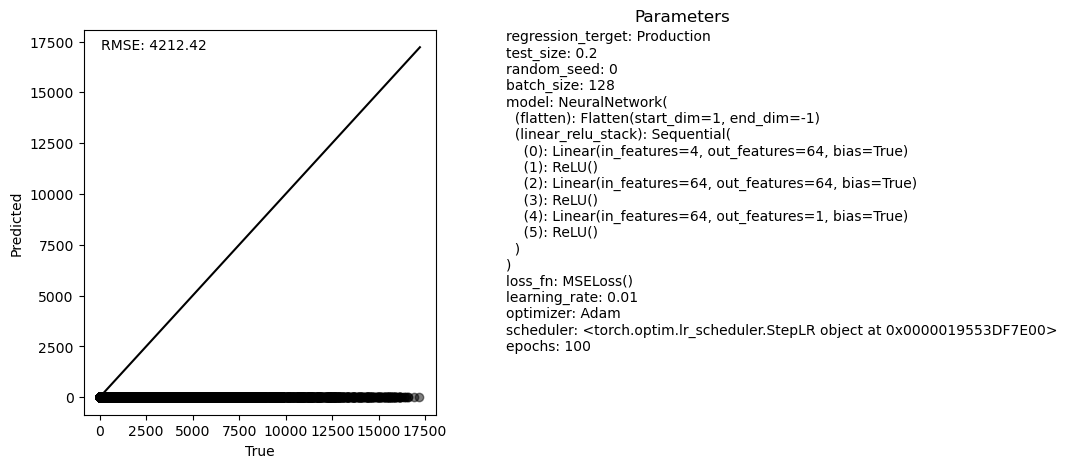

5/30: train_RMSE: 4246.34, test_RMSE: 4212.42(np.float64(0.0), np.float64(17220.0))


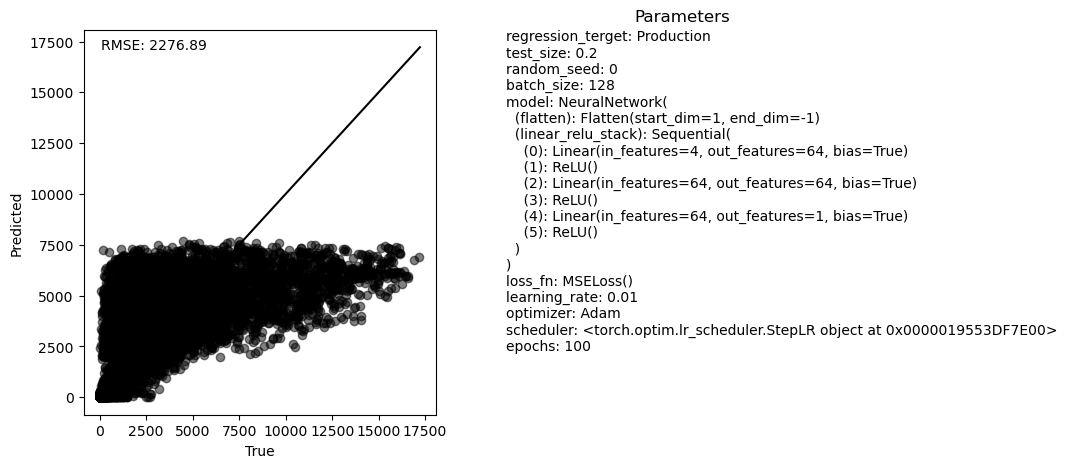

6/30: train_RMSE: 2289.51, test_RMSE: 2276.89(np.float64(0.0), np.float64(17220.0))


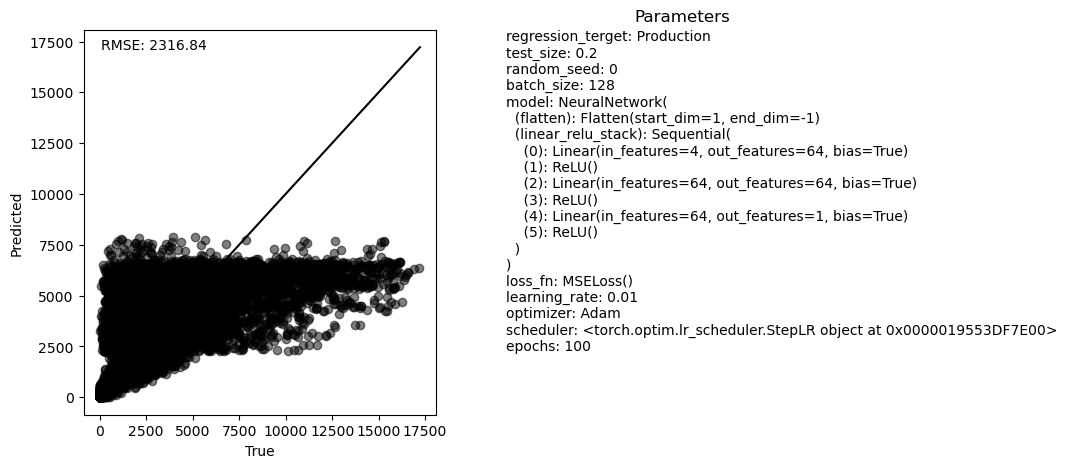

7/30: train_RMSE: 2300.19, test_RMSE: 2316.84(np.float64(0.0), np.float64(17220.0))


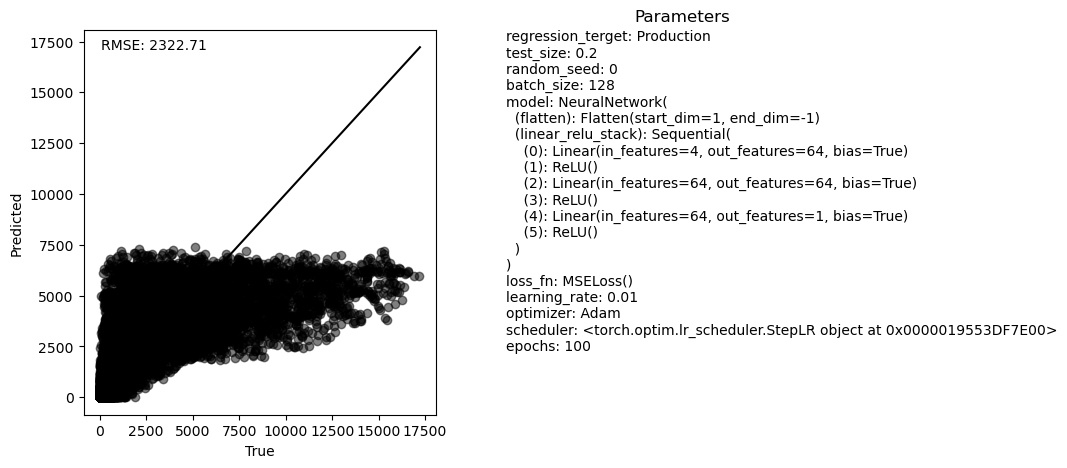

8/30: train_RMSE: 2294.49, test_RMSE: 2322.71(np.float64(0.0), np.float64(17220.0))


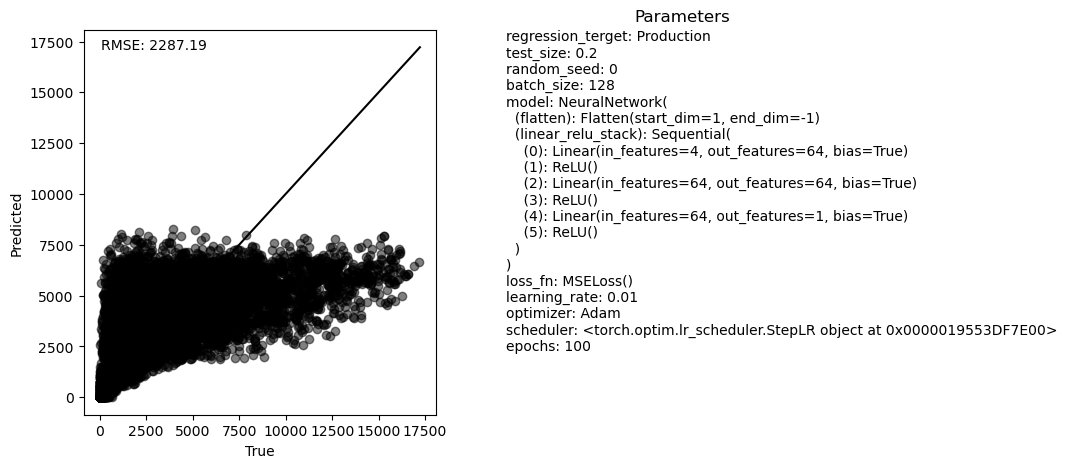

9/30: train_RMSE: 2290.77, test_RMSE: 2287.19(np.float64(0.0), np.float64(17220.0))


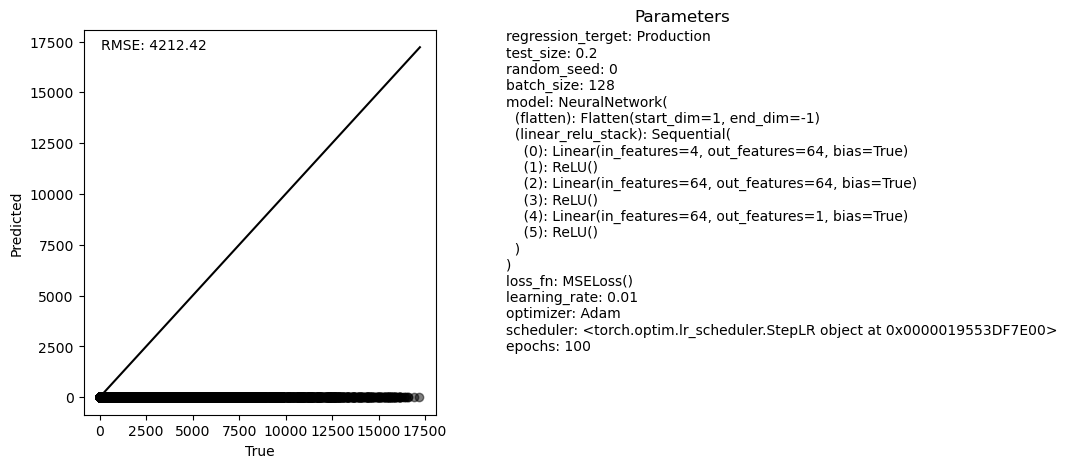

10/30: train_RMSE: 4246.94, test_RMSE: 4212.42(np.float64(0.0), np.float64(17220.0))


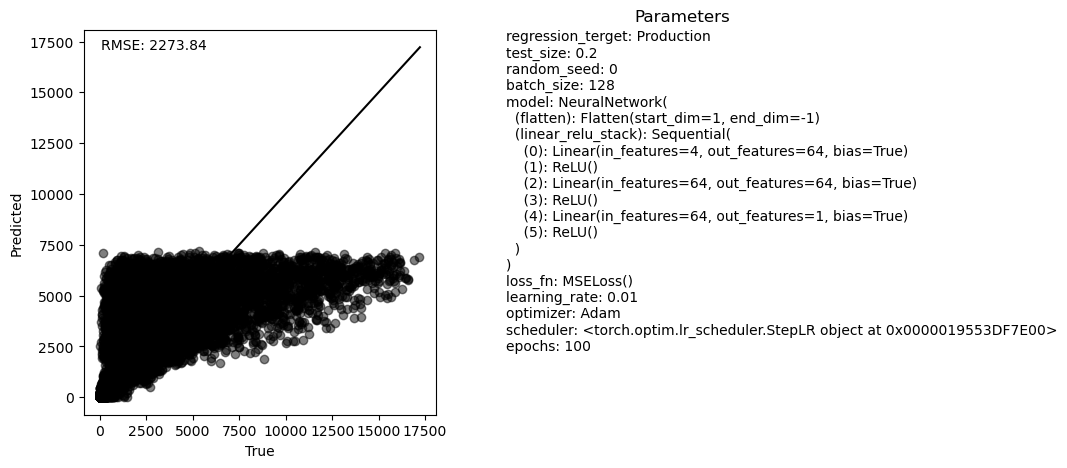

11/30: train_RMSE: 2284.95, test_RMSE: 2273.84(np.float64(0.0), np.float64(17220.0))


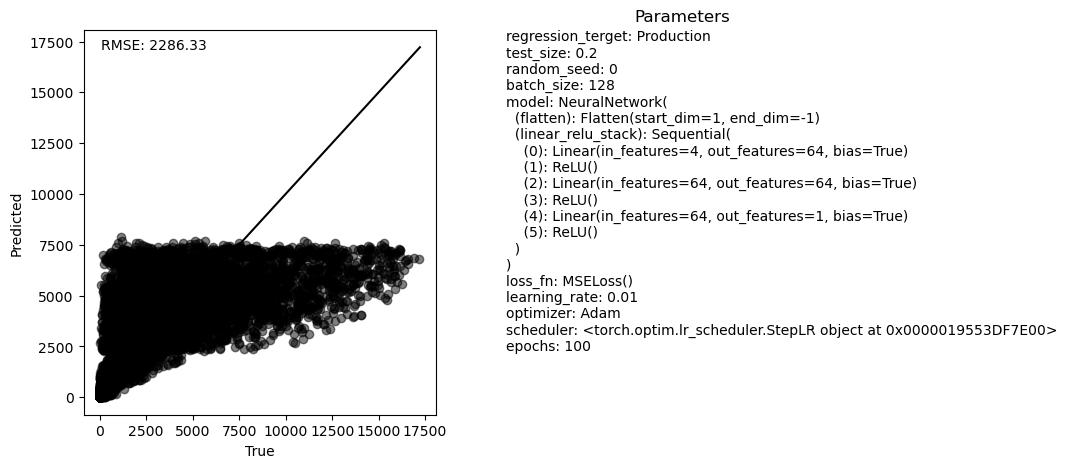

12/30: train_RMSE: 2290.25, test_RMSE: 2286.33(np.float64(0.0), np.float64(17220.0))


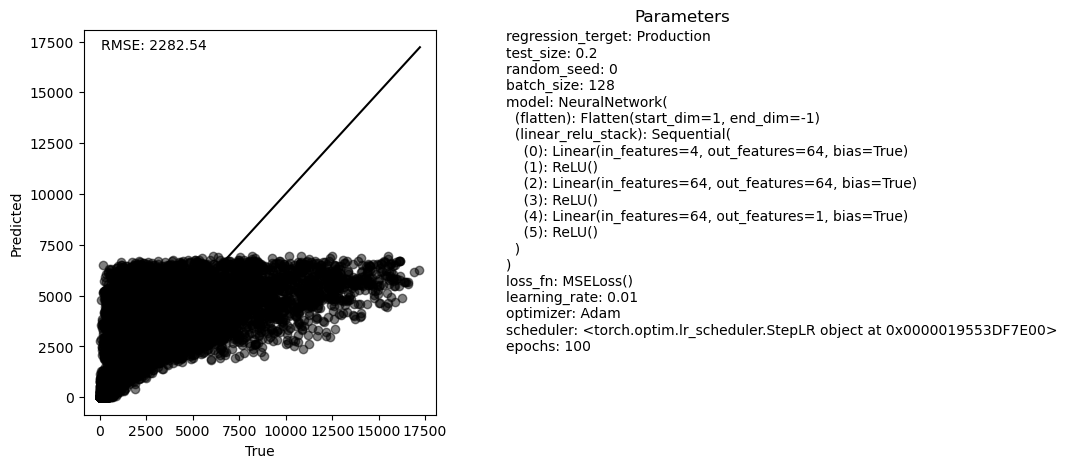

13/30: train_RMSE: 2286.34, test_RMSE: 2282.54(np.float64(0.0), np.float64(17220.0))


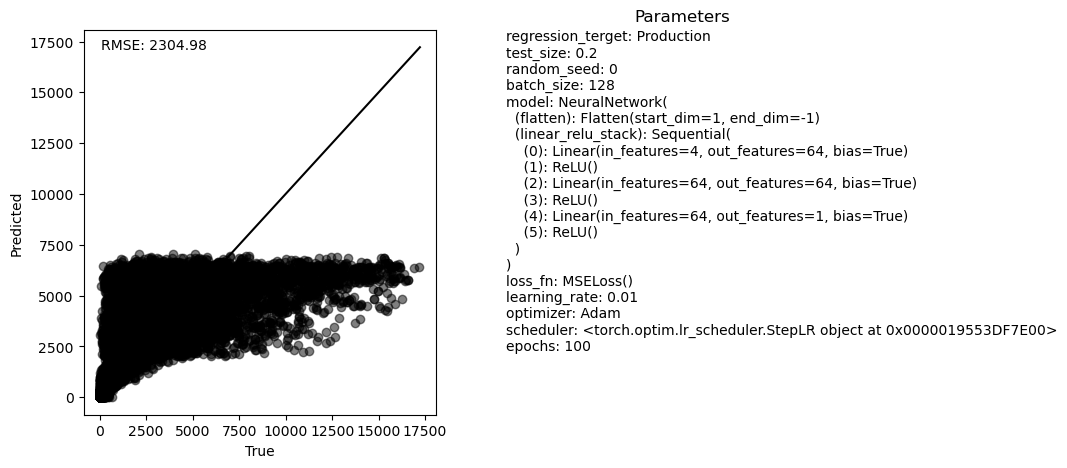

14/30: train_RMSE: 2296.52, test_RMSE: 2304.98(np.float64(0.0), np.float64(17220.0))


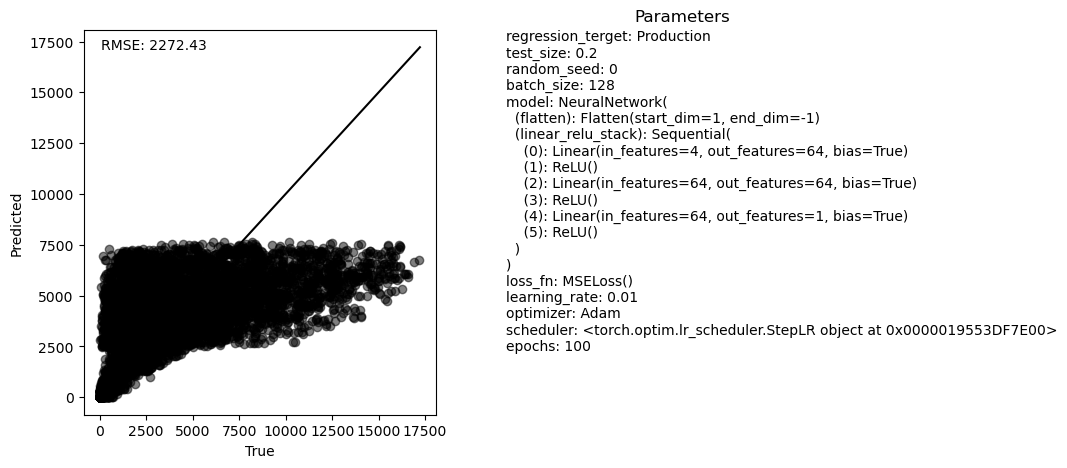

15/30: train_RMSE: 2288.55, test_RMSE: 2272.43(np.float64(0.0), np.float64(17220.0))


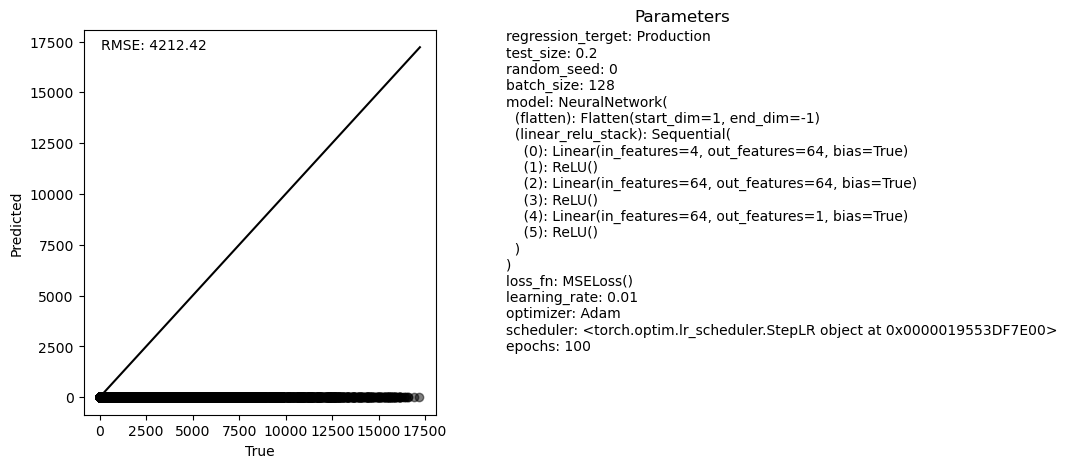

16/30: train_RMSE: 4246.91, test_RMSE: 4212.42(np.float64(0.0), np.float64(17220.0))


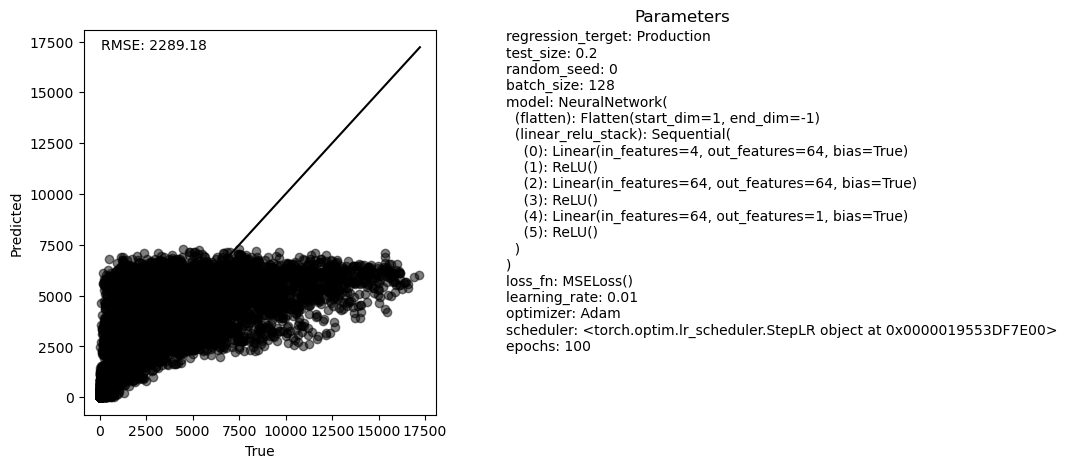

17/30: train_RMSE: 2286.52, test_RMSE: 2289.18(np.float64(0.0), np.float64(17220.0))


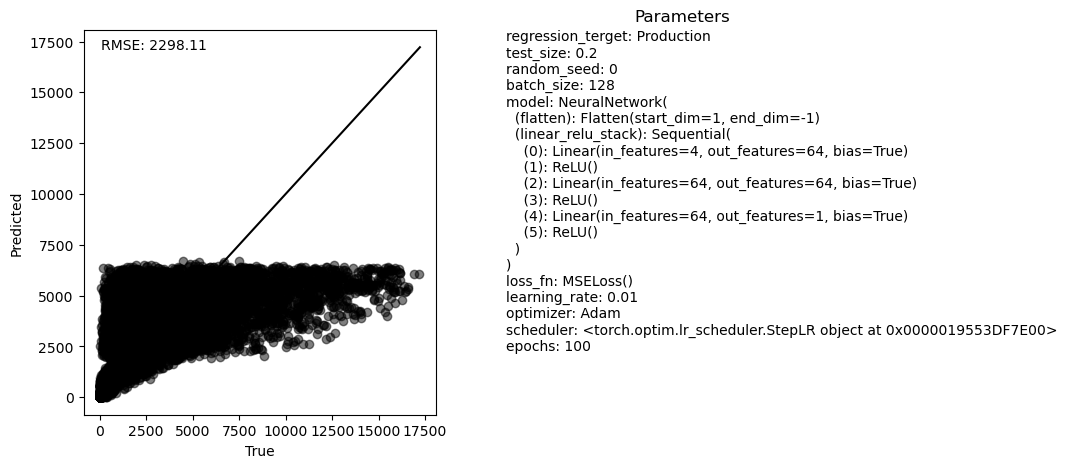

18/30: train_RMSE: 2302.88, test_RMSE: 2298.11(np.float64(0.0), np.float64(17220.0))


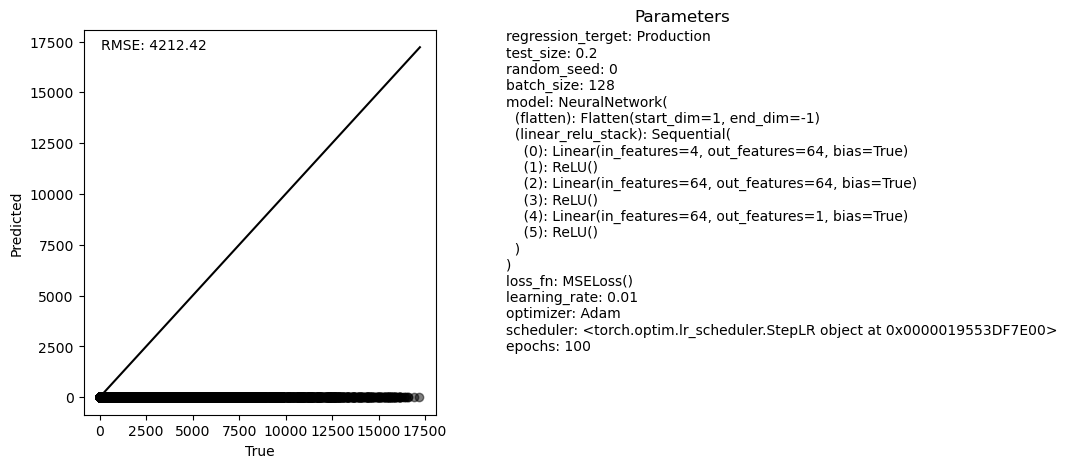

19/30: train_RMSE: 4247.12, test_RMSE: 4212.42(np.float64(0.0), np.float64(17220.0))


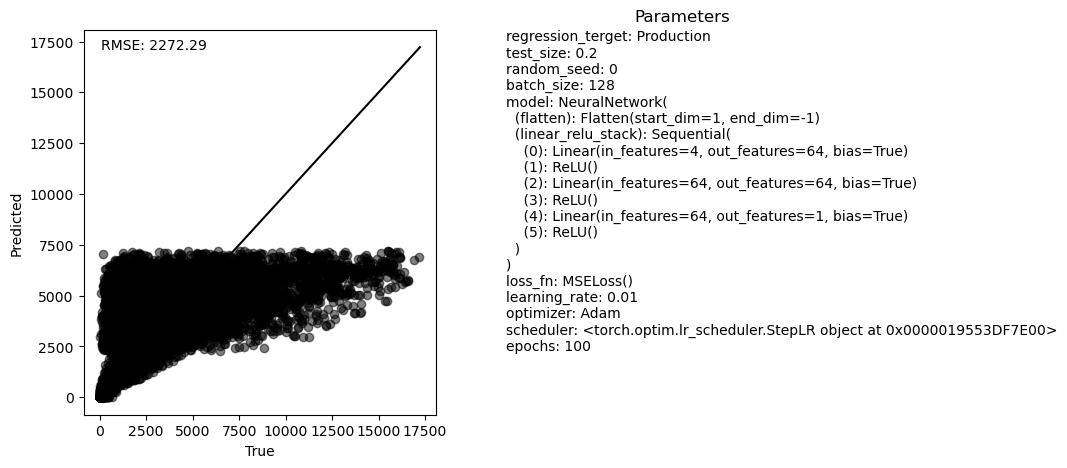

20/30: train_RMSE: 2291.00, test_RMSE: 2272.29(np.float64(0.0), np.float64(17220.0))


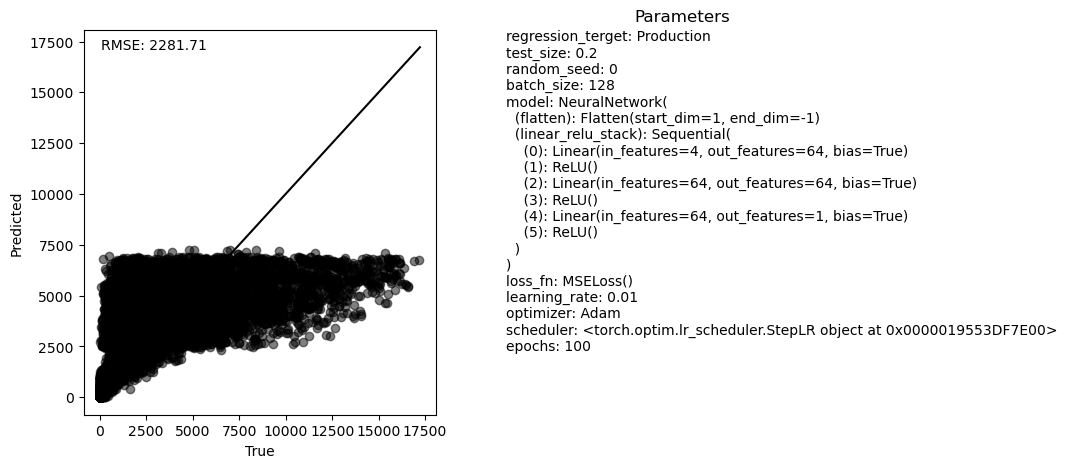

21/30: train_RMSE: 2298.52, test_RMSE: 2281.71(np.float64(0.0), np.float64(17220.0))


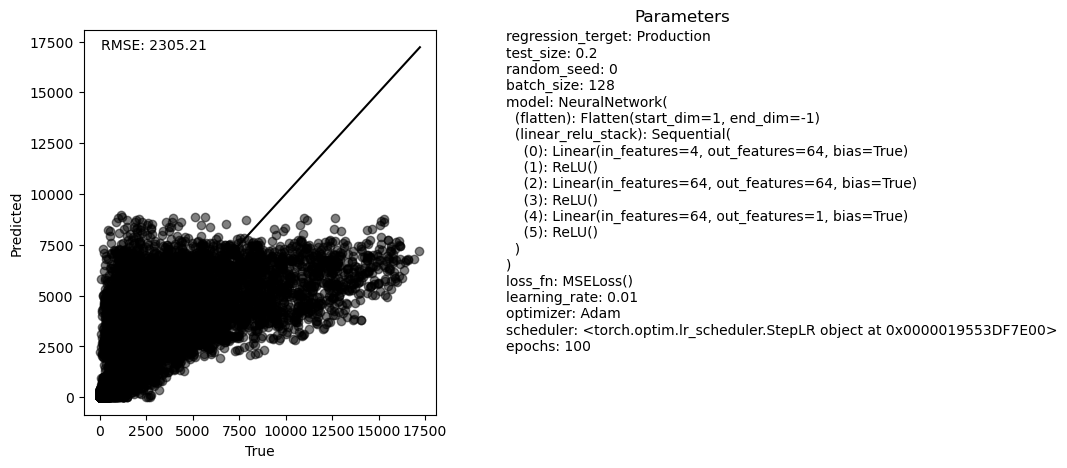

22/30: train_RMSE: 2291.21, test_RMSE: 2305.21(np.float64(0.0), np.float64(17220.0))


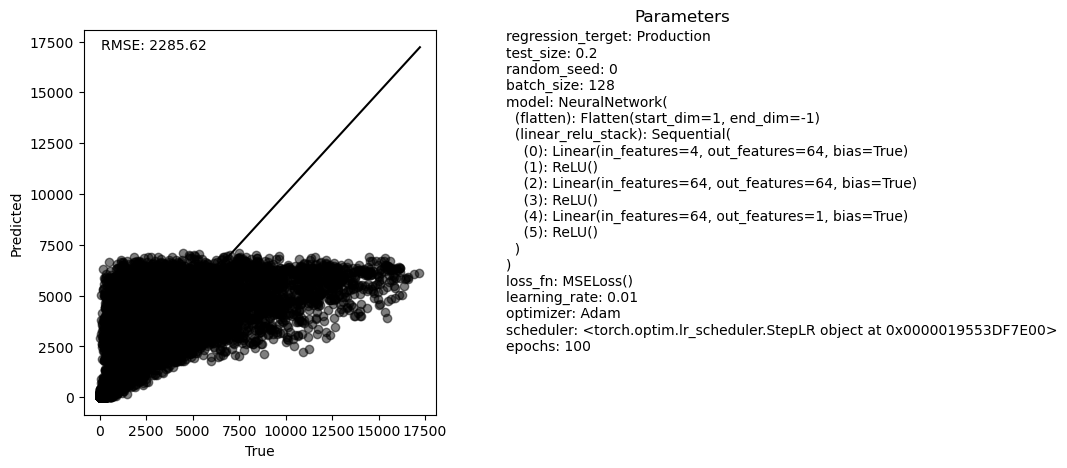

23/30: train_RMSE: 2290.11, test_RMSE: 2285.62(np.float64(0.0), np.float64(17220.0))


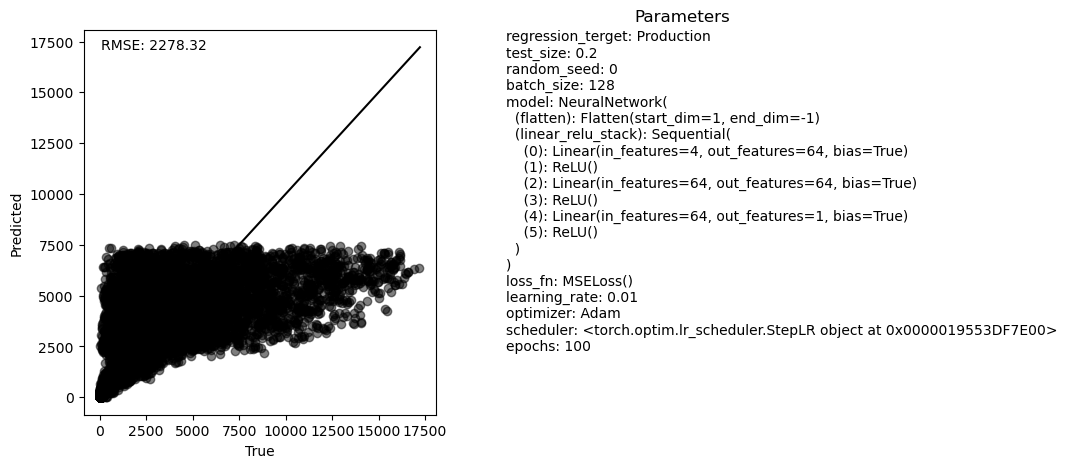

24/30: train_RMSE: 2283.27, test_RMSE: 2278.32(np.float64(0.0), np.float64(17220.0))


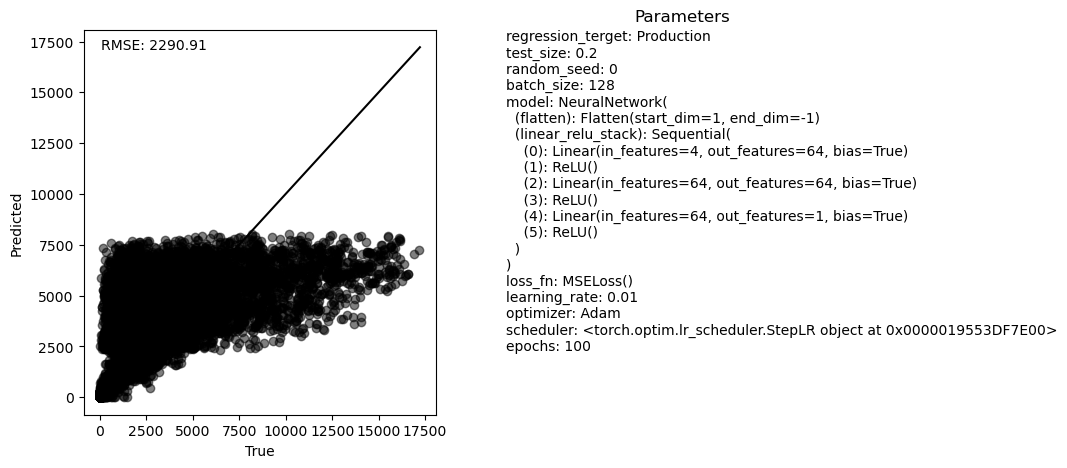

25/30: train_RMSE: 2282.39, test_RMSE: 2290.91(np.float64(0.0), np.float64(17220.0))


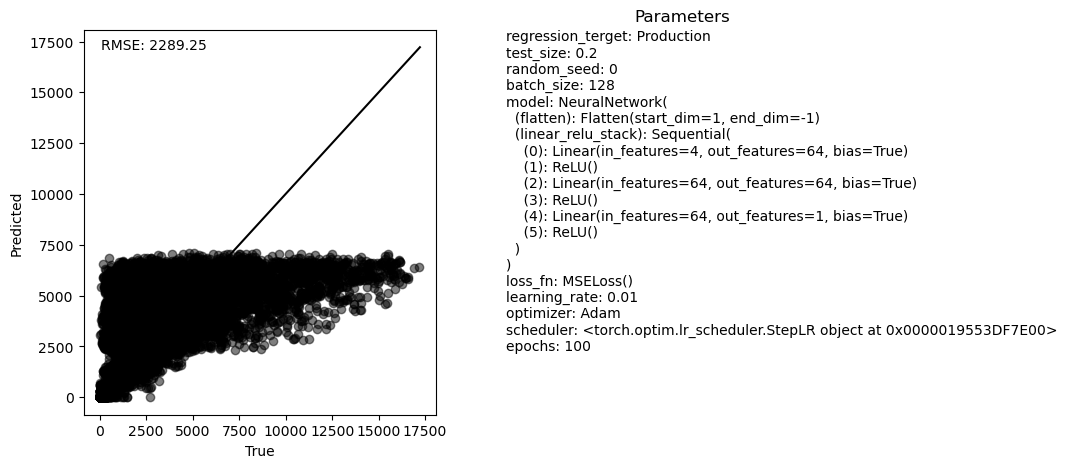

26/30: train_RMSE: 2291.99, test_RMSE: 2289.25(np.float64(0.0), np.float64(17220.0))


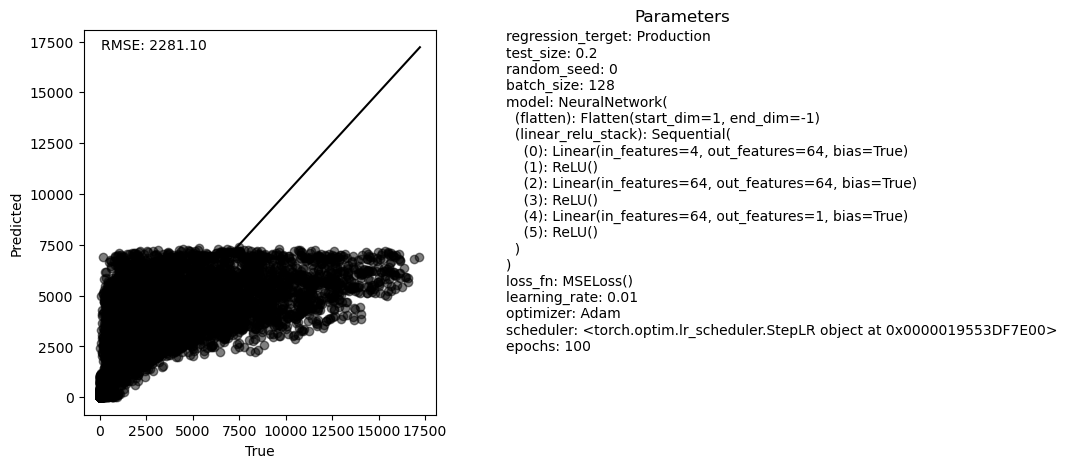

27/30: train_RMSE: 2290.34, test_RMSE: 2281.10(np.float64(0.0), np.float64(17220.0))


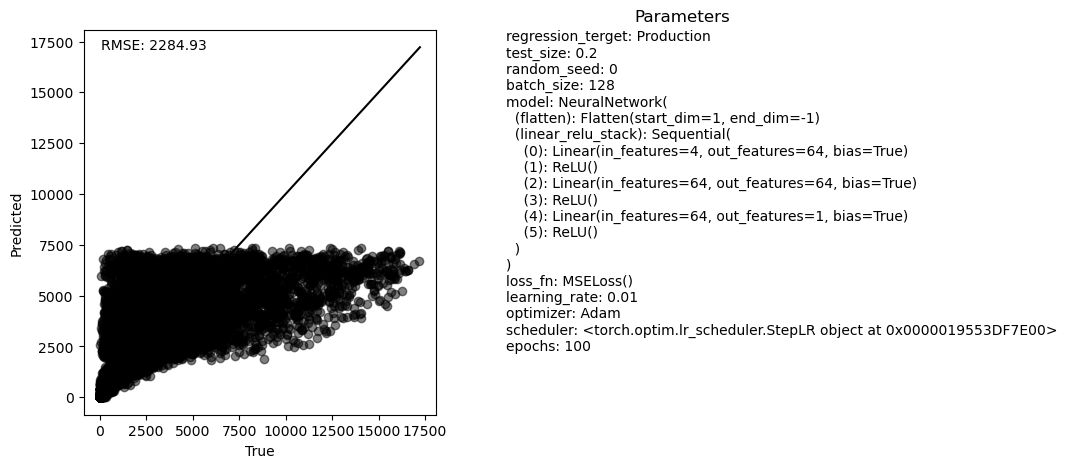

28/30: train_RMSE: 2295.98, test_RMSE: 2284.93(np.float64(0.0), np.float64(17220.0))


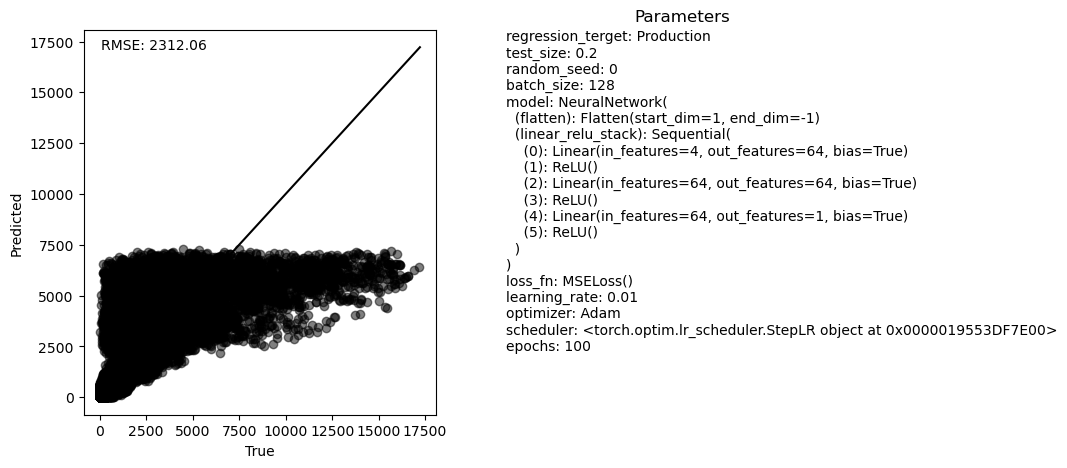

29/30: train_RMSE: 2289.88, test_RMSE: 2312.06(np.float64(0.0), np.float64(17220.0))


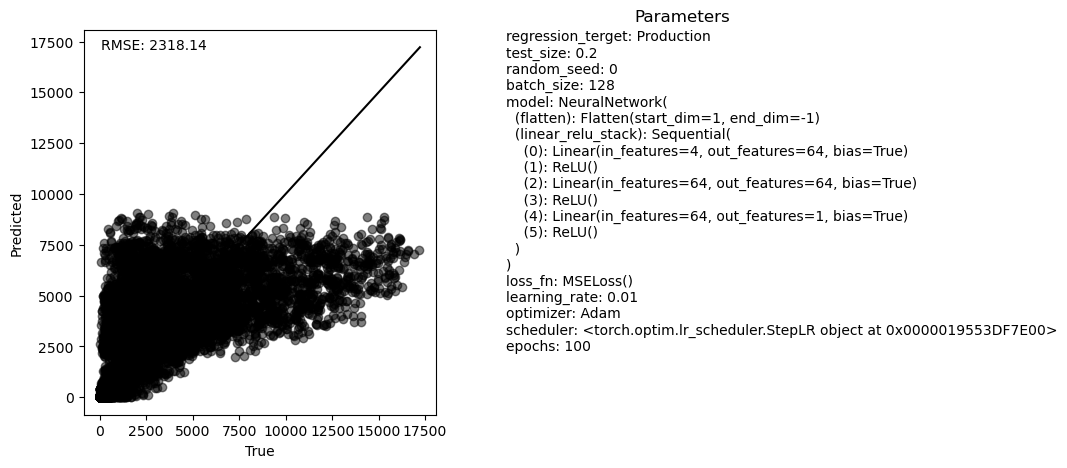

30/30: train_RMSE: 2292.89, test_RMSE: 2318.14

In [25]:
n = 30
errors = []
for i in range(n):
    parameters['model'] = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
    model = parameters.get('model')
    parameters['optimizer'] = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'])
    optimizer = parameters['optimizer']
    #学習スケジューラーを入れる場合はここに記述

    for t in range(parameters['epochs']):
        train_RMSE = train(train_loader, model, loss_fn, optimizer)
    test_RMSE = test(test_loader, model, monitor = True, range = (df[parameters['regression_terget']].min(), df[parameters['regression_terget']].max()))
    errors.append((train_RMSE, test_RMSE))

    print(f"\r{i+1}/{n}: train_RMSE: {train_RMSE:.2f}, test_RMSE: {test_RMSE:.2f}", end='')

(30, 2)


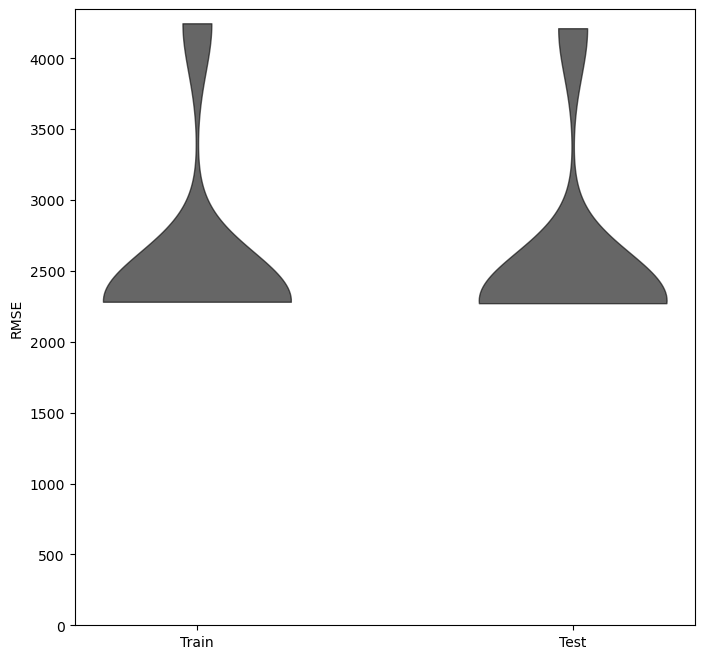

In [26]:
# 繰り返した結果のバイオリンプロットを表示
error = torch.tensor(errors)
error = error.cpu().numpy()
error = error 
print(error.shape)
fig, ax = plt.subplots(figsize=(8,8))
vio = ax.violinplot(error, showmeans=False, showextrema=False, showmedians=False)
ax.set_xticks([1,2], labels=["Train", "Test"])
for body in vio['bodies']:
    body.set_color('black')
    body.set_alpha(0.6)
plt.ylabel("RMSE")
plt.ylim(0, )
plt.show()

In [27]:
# RMSEの統計をcsvに保存
df_error = pd.DataFrame(errors, columns=["Train", "Test"])

# 日付と時刻を取得
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
df_error.to_csv(f"./data/RMSE_{timestamp}.csv")



ここまでを実行すると，繰り返し学習した結果における誤差（RMSE）の分布が"./data/RMSE_{timestamp}.csv"として記録される。

次に，条件を変えた際の筆画を行う。

In [28]:
df_ref = pd.read_csv("./data/RMSE_of_Initial_Conditions.csv")

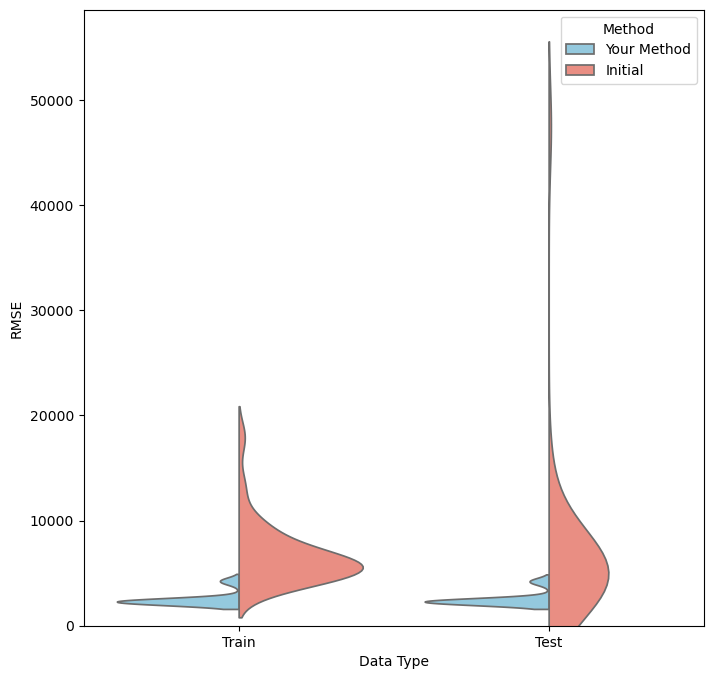

In [29]:
#比較用に整形
df_ref = pd.read_csv("./data/RMSE_of_Initial_Conditions.csv")
df_ref_train = pd.DataFrame({'RMSE': df_ref['Train']})
df_ref_train['Data Type'] = 'Train'
df_ref_test = pd.DataFrame({'RMSE': df_ref['Test']})
df_ref_test['Data Type'] = 'Test'
df_ref_combined = pd.concat([df_ref_train, df_ref_test])
df_ref_combined['Method'] = 'Initial'

df_error_train = pd.DataFrame({'RMSE': df_error['Train']})
df_error_train['Data Type'] = 'Train'
df_error_test = pd.DataFrame({'RMSE': df_error['Test']})
df_error_test['Data Type'] = 'Test'
df_error_combined = pd.concat([df_error_train, df_error_test])
df_error_combined['Method'] = 'Your Method'

df_combined = pd.concat([df_error_combined, df_ref_combined])

#比較
f,ax=plt.subplots(figsize=(8,8))
sns.violinplot(x= "Data Type",y="RMSE",hue="Method", data=df_combined, split=True, ax=ax, inner=None, palette=["skyblue", "salmon"])
ax.set_ylabel("RMSE")
ax.set_ylim(0,)
plt.show()


In [30]:
df_combined

RMSE Data Type       Method
0   2293.122825     Train  Your Method
1   2292.065906     Train  Your Method
2   2288.826246     Train  Your Method
3   2289.689956     Train  Your Method
4   4246.338779     Train  Your Method
..          ...       ...          ...
25  5122.031823      Test      Initial
26  5126.554398      Test      Initial
27  4893.341803      Test      Initial
28  4643.335439      Test      Initial
29  4178.405916      Test      Initial

[120 rows x 3 columns]

### プレゼンに向けて
与えられたコードを改良し, データに対する回帰の精度を向上させ, 結果を2分のプレゼンテーションで説明せよ​。スライドには変更点と実験結果の説明を含めること​。例えば以下のような変更点が考えられる​。

1. 学習条件（エポック数, 学習係数, バッチサイズ)​

1. モデル条件（層の種別, 組み合わせ, モデルの構造)​

1. 前処理に関する変更点（正規化, 情報の種別）​

### 実験結果には以下のものを含めること​

1. テストデータに対するyyplot​

1. 改善後のRMSE値（可能であればバイオリンプロット）​

1. 結果に対する考察​


In [31]:
from IPython.display import SVG, display
display(SVG("./figure/ルーブリック2.svg"))


ExpatError: not well-formed (invalid token): line 1, column 1